# Text Prediction

This notebook is a running analysis on the Kaggle "spooky author" dataset.

### Introduction

This notebook takes you through an approach to small document text classification. It takes you through basic approaches to vectorizing and training text classification models and then builds up from there to stack model approaches that yield more powerful predictions. The notebook is organized as follows:

1. Initial Data Exploration
2. Basic Text Feature Engineering and Model Evaluation
3. Extracting Text Meta-Features
4. Stack Model Approaches
5. Cross-Validation and Visualizing Performance
6. Closing Remarks

### Initial Data Exploration

Let's first import our libraries and our training and testing data sets. You'll see below I rely heavily on the scikit and nltk libraries in my text classification analysis.

In [72]:
import pandas as pd
import numpy as np
import re

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import ngrams, pos_tag

import matplotlib.pyplot as plt

In [2]:
## import training and test data
train_df, test_df = pd.read_csv("train.csv", sep=",", encoding="utf-8"), pd.read_csv("test.csv", sep=",", encoding="utf-8")

##### Plot Our Class Distribution

Let's start off by plotting our training data class distributions. It's always good to make sure our class distribution is not lopsided (think cancer data) and that we have a basic, high level understanding of our class occurences (e.g. how many classes we need to train on, et cetera).

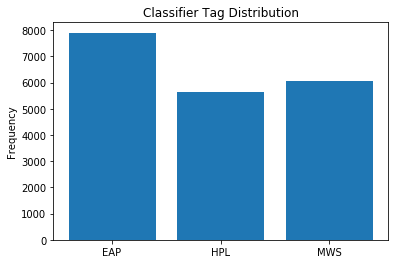

In [3]:
## plot overall author count
classDist = train_df.groupby("author")["id"].count().reset_index().rename(columns={'id':'count'})

plt.bar(list(classDist.author.index), classDist['count'])
plt.title("Classifier Tag Distribution")
plt.ylabel("Frequency")
plt.xticks(list(classDist.author.index), classDist.author)

plt.show()

As far as class distributions go this is pretty manageable. We'll just want to make sure our train and test splits mirror this distribution.

##### Preparing Our Text Data

We need to run some pre-processing on our data. It varies based upon the project, but typically you'll at least consider doing some of the following:
- Stripping special characters (non-alpha-numeric characters) from the raw strings
- Tokenizing
- Removing stopwords
- Stem/lemmatize
- Generate count or tfidf sparse vectors

But again: not every action is needed or even desirable given the particular problem case. For instance, special characters might very well help our models distinguish between authors. One of our authors lived relatively later than our other two and punctuation conventions change over time (and are usually idiosyncratic when considering some famous authors). So we might very well want to hold back on the string cleaning.

Tokenizing is another task that's going to have its specifics be determined by the project's aims as well as data available. The second consideration is very important: bi-gram and tri-grams require a fairly substantial corpus, preferably at least in the millions -- the reason being we need a lot of overall occurences before we can get a decent sample of co-occurences. We don't have that here, but then again, authorial idiosyncracies might reveal an important ngram or two.

I've defined a method that gives us some flexibility in configuring our parameters so we can test to see which pre-processing tasks we want to perform on our data.

In [4]:
def joinGrams(text, n_count):
    return [" ".join(n) for n in ngrams(text, n_count)]

def buildNGrams(text, n_count):
    result = []
    for i in range(n_count[0],n_count[1]+1):
        result += joinGrams(text, i)
    return result

def buildCorpus(sentences, flatten=False, n_count=(1,1)):
    stemmer = PorterStemmer()
    stop = list(set(stopwords.words('english')))
    
    ## tokenize
    corp = [word_tokenize(re.sub("[^a-z]", " ", s.lower())) for s in sentences]
    
    ## remove stopwords (first sweep)
    corp = [[w for w in sen if w not in stop] for sen in corp]
    
    ## stem words
    corp = [[stemmer.stem(w) for w in sen] for sen in corp]

    ## remove stopwords (second sweep)
    corp = [[w for w in sen if w not in stop] for sen in corp]

    ## build ngrams
    if n_count[1] > 1:
        corp = [buildNGrams(c, n_count) for c in corp]
    
    ## return flattened list
    if flatten is True:
        return [item for sublist in corp for item in sublist]
    else:
        return corp

Let's start off simple: we'll remove our stopwords, clean, and stem. I'm going to create separate vectors holding our uni-grams and bi-grams. For bi-grams to be useful we'll likely need a larger corpus, but let's at least see what we have to work with.

(Note: sklearn has classes that do this for you, but for illustrative purposes I've defined a simple method for us to play with).

Below I generate lists of every token (uni or bigram) present in an author's corpus (i.e. no de-duplication). These lists will help us analyze term frequencies.

In [5]:
## generate list of all unigrams found in an author's corpus
eap_1tok = buildCorpus(train_df.text[train_df.author == "EAP"], flatten=True)
hpl_1tok = buildCorpus(train_df.text[train_df.author == "HPL"], flatten=True)
mws_1tok = buildCorpus(train_df.text[train_df.author == "MWS"], flatten=True)

## generate list of all bigrams found in an author's corpus
eap_2tok = buildCorpus(train_df.text[train_df.author == "EAP"], flatten=True, n_count=(2,2))
hpl_2tok = buildCorpus(train_df.text[train_df.author == "HPL"], flatten=True, n_count=(2,2))
mws_2tok = buildCorpus(train_df.text[train_df.author == "MWS"], flatten=True, n_count=(2,2))

## generate list of all unigrams in entire corpus, both training and test
train_1tok = buildCorpus(train_df.text, flatten=True)
test_1tok = buildCorpus(test_df.text, flatten=True)

## generate list of all bigrams in entire corpus, both training and test
train_2tok = buildCorpus(train_df.text, flatten=True, n_count=(2,2))
test_2tok = buildCorpus(test_df.text, flatten=True, n_count=(2,2))

Below I visualize aggregate frequency statistics that will help give us a bird's eye sense of the data we're playing with. But let's first simply get a sense of token count and uniqueness throughout our population.

In [6]:
print("Total number of unigram tokens in training corpus: {}".format(len(train_1tok)))
print("Total number of bigram tokens in training corpus: {}".format(len(train_2tok)))

print("\nTotal number of unique unigram tokens in training corpus: {}".format(len(set(train_1tok))))
print("Total number of unique bigram tokens in training corpus: {}".format(len(set(train_2tok))))

Total number of unigram tokens in training corpus: 255549
Total number of bigram tokens in training corpus: 235974

Total number of unique unigram tokens in training corpus: 15429
Total number of unique bigram tokens in training corpus: 201168


This corpus is not that big. At ~250,000 tokens and a roughly 17:1 total to unique ratio we'll easily be able to build classifiers using unigram tokens. But 235,000 tokens is simply not enough for bigrams as is evidenced by the total to unique ratio: 1.15:1; we simply do not have enough bigram observations to build a model on a lrge bi-gram vector.

As we'll see below, there are a few frequently occuring bi-grams, so we could consider hot coding this into one of our vectors and seeing how our models respond.

###### Visualizing Most Frequent One-Gram Tokens, by Author

In [7]:
def mostFreq(items, n, return_key=True):
    counter = Counter(items)
    if return_key is True:
        return [c[0] for c in counter.most_common(n)]
    else:
        return [c[1] for c in counter.most_common(n)]

def jaccord(set_1, set_2):
    return len(set(set_1).intersection(set(set_2))) / float(len(set(set_1).union(set(set_2))))

In [8]:
def similarity(set_1, set_2):
    cycles = [10 * n for n in range(1,200)]
    step, score = [], []
    for c in cycles:
        freq1, freq2 = mostFreq(set_1, c), mostFreq(set_2, c)
        step.append(c)
        score.append(jaccord(freq1, freq2))
    return [step, score]

eap_hpl1 = similarity(eap_1tok, hpl_1tok)
eap_mws1 = similarity(eap_1tok, mws_1tok)
mws_hpl1 = similarity(mws_1tok, hpl_1tok)

eap_hpl2 = similarity(eap_2tok, hpl_2tok)
eap_mws2 = similarity(eap_2tok, mws_2tok)
mws_hpl2 = similarity(mws_2tok, hpl_2tok)

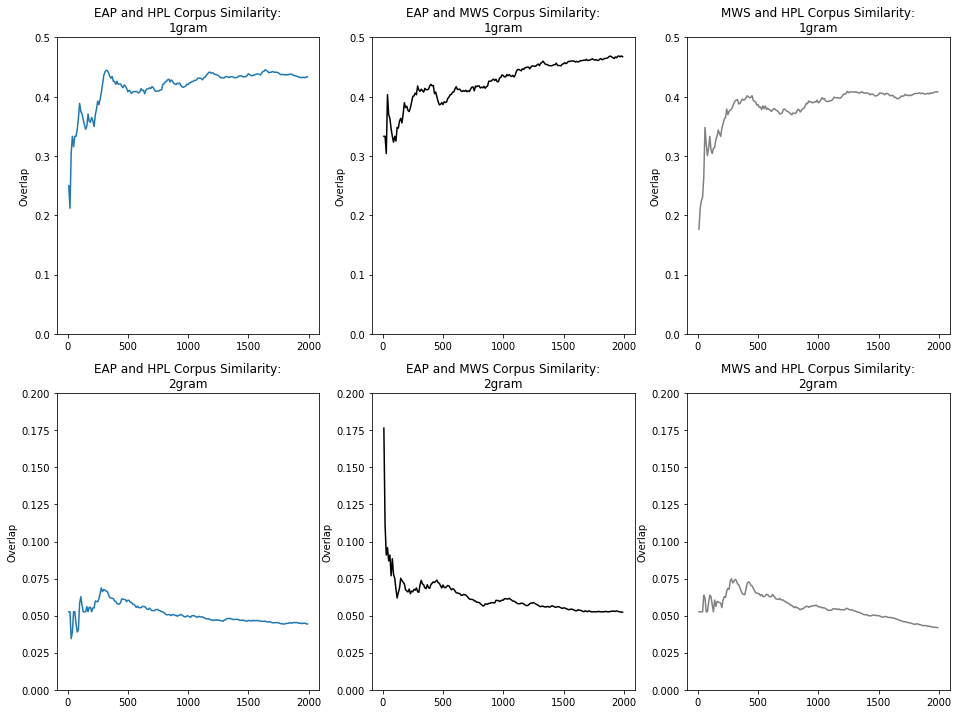

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,12))

ax[0][0].plot(eap_hpl1[0], eap_hpl1[1])
ax[0][1].plot(eap_mws1[0], eap_mws1[1], color="black")
ax[0][2].plot(mws_hpl1[0], mws_hpl1[1], color="grey")

ax[1][0].plot(eap_hpl2[0], eap_hpl2[1])
ax[1][1].plot(eap_mws2[0], eap_mws2[1], color="black")
ax[1][2].plot(mws_hpl2[0], mws_hpl2[1], color="grey")

ax[0][0].set_title("EAP and HPL Corpus Similarity:\n1gram")
ax[0][1].set_title("EAP and MWS Corpus Similarity:\n1gram")
ax[0][2].set_title("MWS and HPL Corpus Similarity:\n1gram")

ax[1][0].set_title("EAP and HPL Corpus Similarity:\n2gram")
ax[1][1].set_title("EAP and MWS Corpus Similarity:\n2gram")
ax[1][2].set_title("MWS and HPL Corpus Similarity:\n2gram")

ax[0][0].set_ylabel("Overlap")
ax[0][1].set_ylabel("Overlap")
ax[0][2].set_ylabel("Overlap")

ax[1][0].set_ylabel("Overlap")
ax[1][1].set_ylabel("Overlap")
ax[1][2].set_ylabel("Overlap")

ax[0][0].set_ylim(0,.5)
ax[0][1].set_ylim(0,.5)
ax[0][2].set_ylim(0,.5)

ax[1][0].set_ylim(0,.2)
ax[1][1].set_ylim(0,.2)
ax[1][2].set_ylim(0,.2)

plt.show()

From the two plot sets, both Shelley and Lovecraft share affinities with Poe though likely for different reasons. Shelley and Poe were contemporaries, thus it's likely that they shared phrasings and word choice that were common during their era. Lovecraft's similarity with Poe likely derives from influence. Interestingly, Shelley and Lovecraft and noticeably less similar with each other than they are with Poe. It's possible that these similarities might confuse our models, so it's important to return to this observation during model evaluation.

Second, it's worth mentioning how distinct bigram usage is among the three authors. We need to be careful though because of the limited size of our corpus. Low co-occurence account could lead to classifier instabilities so we'll need to strategize how best to incorporate this information that clearly separates our authors far more than does the 1-gram results. It's also interesting to note how Shelley and Lovecraft have a relatively steep long-tail decline in corpus similarity.

##### Exploring BiGrams Further

BiGrams are obviously important, yet our small corpus size is a roadblock to fully leveraging this information. We need to see assess how common these bigrams are.

Below I plot the frequencies of the most common 1-grams vs. the most common bigrams.

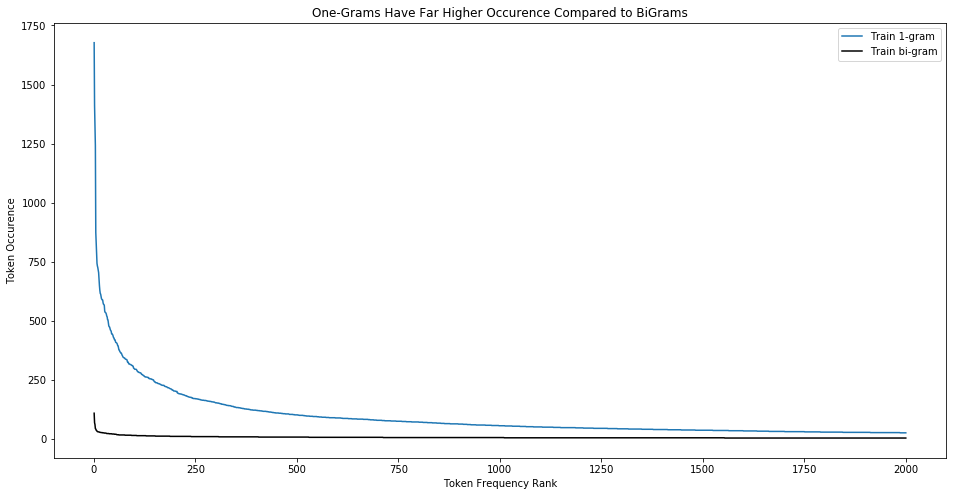

In [10]:
trainGram1Freq = mostFreq(train_1tok, 2000, return_key=False)
trainGram2Freq = mostFreq(train_2tok, 2000, return_key=False)

fig, ax = plt.subplots(figsize=(16,8))

ax.plot([n for n in range(1, 2001)], trainGram1Freq)
ax.plot([n for n in range(1, 2001)], trainGram2Freq, color="black")
ax.set_title("One-Grams Have Far Higher Occurence Compared to BiGrams")
ax.set_ylabel("Token Occurence")
ax.set_xlabel("Token Frequency Rank")
ax.legend(["Train 1-gram", "Train bi-gram"])

plt.show()

The observed bigram frequencies are so low it's doubtful that they'll be of much help to our models. Indeed, the unigram counts too are *quite low* once we surpass the top 100! Given this fact, it might be useful to at least trying to rollup these token features via TruncatedSVD. 

### Building Classifiers Using Text Features

Typically in these problems the baseline approach is to build out a sparse vector of tfidf values for you ngrams and train/test some preliminary models. One wrinkle I want to introduce is how we incorporate grams of varying size.

N grams of length > 1 are by definition co-occuring, so when we have a vector of uni and bigrams, we're double counting in a sense (violating our independence assumptions). For instance, the bigram "old person" will also appear in our vector as "old" and "person".

Two potential ways we can tackle this problem are as follows:

1. Separate our ngrams into separate vectors to train different models. If errors are fairly uncorrelated, it'd make sense to stack the results.
2. Defer to the highest ngram and only count the lower instances if the remaining tokens in the larger ngram are not co-occuring with the lower ngram in the text sample. So for instance: "the old person left the tired, old room". Let's say we have ["old", "old person"] as text features. In the typical approach, our count dictionary would be {"old":2, "old person":1}, when really it should be {"old":1, "old person":1}

In [11]:
## build separate tfidf vectors
def buildTfidf(train, count, n_count):
    corpus = [" ".join(c) for c in buildCorpus(train, n_count=n_count)]
    return TfidfVectorizer(max_features=count).fit_transform(corpus)

In [12]:
tfidf = buildTfidf(train_df.text, 4000, (1,1))

In [13]:
## set aside target
y = train_df.author.as_matrix().ravel()

## train/test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf, y, random_state=0, stratify=y)

In [14]:
def printConfusion(y_act, y_pred):
    cm = confusion_matrix(y_act, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(pd.DataFrame(cm))
    print(pd.DataFrame(cm_norm))

In [15]:
mnb = MultinomialNB(alpha=.1).fit(X_train, y_train)
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))
print("MNB F1 Score: {:.3f}".format(f1_score(y_test, mnb.predict(X_test), average='weighted')))

printConfusion(y_test, mnb.predict(X_test))

Training set score: 0.864
Test set score: 0.803
MNB F1 Score: 0.803
      0     1     2
0  1648   127   200
1   233  1080    96
2   225    83  1203
          0         1         2
0  0.834430  0.064304  0.101266
1  0.165366  0.766501  0.068133
2  0.148908  0.054931  0.796161


### Meta Features

In [133]:
def findUnique(items, pop):
    return list(set([i for i in items if i not in pop]))

def tokCount(items):
    return [len(i) for i in items]

def meanTokLen(items):
    return list(pd.Series([np.mean([len(t) for t in i]) for i in items]).fillna(0))

def characterCount(items):
    return [len(list(s)) for s in [" ".join(i) for i in items]]

def posCount(items):
    results = pd.DataFrame()
    for i in items:
        row = {}
        tags = pos_tag(i)
        for t in tags:
            if row.get(t[1], None) is not None:
                row[t[1]] += 1
            else:
                row[t[1]] = 1
        row = pd.DataFrame(pd.Series(row)).T
        results = results.append(row)
    return results.fillna(0).reset_index(drop=True)

def specCharCount(items):
    return [len(list(re.sub("[a-z0-9]", "", i.lower()))) for i in items]

In [17]:
train_corp = buildCorpus(train_df.text, n_count=(1,1))

In [170]:
pos = posCount(train_df.text)
pos = TruncatedSVD(n_components=2).fit_transform(pos.as_matrix())

In [188]:
meta_df = pd.concat([pd.DataFrame(pos), pd.DataFrame(mnb.predict_proba(tfidf))], axis=1)
#meta_df = pd.DataFrame(mnb.predict_proba(tfidf))

In [189]:
#meta_df['tokCount'] = tokCount(train_corp)
#meta_df['mean_tok_len'] = meanTokLen(train_corp)
meta_df['char_count'] = characterCount(train_corp)
#meta_df['special_char'] = specCharCount(train_df.text)

In [190]:
#meta_df = pd.concat([meta_df, pd.DataFrame(mnb.predict_proba(tfidf))], axis=1)
#meta_df = pd.DataFrame(mnb.predict_proba(tfidf))

In [191]:
uniq_tok = [
    set(findUnique(eap_1tok, set(hpl_1tok).union(set(mws_1tok)))),
    set(findUnique(hpl_1tok, set(eap_1tok).union(set(mws_1tok)))),
    set(findUnique(mws_1tok, set(hpl_1tok).union(set(eap_1tok))))
]
u_df = pd.DataFrame()
for t in train_corp:
    matches = []
    for e in uniq_tok:
        if len(set(t).intersection(e)) > 0:
            matches.append(1)
        else:
            matches.append(0)
    u_df = u_df.append(pd.DataFrame(matches).T)

u_df.head()
meta_df = pd.concat([meta_df, u_df.reset_index(drop=True)], axis=1)

In [192]:
scaler = StandardScaler()
X_meta = meta_df.as_matrix()

X_meta = scaler.fit_transform(X_meta)

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta, y, random_state=0, stratify=y)

In [193]:
knn = KNeighborsClassifier(n_neighbors=20).fit(X_train_meta, y_train_meta)
print("Training set score: {:.3f}".format(knn.score(X_train_meta, y_train_meta)))
print("Test set score: {:.3f}".format(knn.score(X_test_meta, y_test_meta)))
print("KNN F1 Score: {:.3f}".format(f1_score(y_test_meta, knn.predict(X_test_meta), average='weighted')))

printConfusion(y_test_meta, knn.predict(X_test_meta))

Training set score: 0.918
Test set score: 0.882
KNN F1 Score: 0.882
      0     1     2
0  1780    68   127
1   109  1250    50
2   179    45  1287
          0         1         2
0  0.901266  0.034430  0.064304
1  0.077360  0.887154  0.035486
2  0.118465  0.029782  0.851754


In [194]:
gbc = GradientBoostingClassifier().fit(X_train_meta, y_train_meta)
print("Training set score: {:.3f}".format(gbc.score(X_train_meta, y_train_meta)))
print("Test set score: {:.3f}".format(gbc.score(X_test_meta, y_test_meta)))
print("RF F1 Score: {:.3f}".format(f1_score(y_test_meta, gbc.predict(X_test_meta), average='weighted')))

printConfusion(y_test_meta, gbc.predict(X_test_meta))

Training set score: 0.925
Test set score: 0.879
RF F1 Score: 0.879
      0     1     2
0  1765    69   141
1   121  1239    49
2   167    44  1300
          0         1         2
0  0.893671  0.034937  0.071392
1  0.085877  0.879347  0.034776
2  0.110523  0.029120  0.860357


In [195]:
for f, i in zip(meta_df.columns, gbc.feature_importances_):
    print f, i

0 0.132959616621
1 0.0583228932153
0 0.177234040473
1 0.224559774585
2 0.178063629924
char_count 0.067167908147
0 0.0476488748417
1 0.0719529063819
2 0.0420903558114
